In [1]:
import os
import sys
import yaml
import numpy as np
import re
from pathlib import Path
from scipy import stats
path_folder = '/home/bdebian/Documents/Projects/Stoke_prediccition/app_prediction/'
omitir = ''

def search_subfolders(path:str):
    '''Funcion para agregar rutas al path de ejecucion'''
    folder = []
    for root, dirs, _ in os.walk(path, topdown=False):
        for name in dirs:
            if name == omitir:
                print(f"[INFO] carpeta omitida: {name}")
            else:
                folder.append(os.path.join(root, name))
    return folder


for i in search_subfolders(path_folder):
    sys.path.insert(0, i)

from class_load import LoadFiles
from factory_data import SQLDataSourceFactory, get_data, HandleRedis
from factory_models import ModelContext  # , Modelos, Parameters_model
from factory_prepare_data import (DataCleaner, DataModel,
                                          MeanImputation, OutliersToIQRMean)
from factory_data import SQLDataSourceFactory, get_data, create_table, set_data
from features_fix_data import PrepareData

import pandas as pd
from DP_model import Modelos,Parameters_model
from args_data_model import Parameters


attempted relative import with no known parent package


In [2]:
from matplotlib import pyplot as plt
from matplotlib import cm
from darts.metrics import mape, r2_score, mse,mase,rmse,rho_risk, smape
def display_forecast(pred_series, ts_transformed, forecast_type, start_date=None):
    plt.figure(figsize=(8, 5))
    if start_date:
        ts_transformed = ts_transformed.drop_before(start_date)
    ts_transformed.univariate_component(0).plot(label="actual")
    pred_series.plot(label=("historic " + forecast_type + " forecasts"))
    plt.title(
        "R2: {}".format(r2_score(ts_transformed.univariate_component(0), pred_series))
    )
    plt.legend()

In [3]:

handler_load = LoadFiles()
handler_redis = HandleRedis()
# ruta_actual = os.path.dirname(__file__)
ruta_actual = "/home/bdebian/Documents/Projects/Stoke_prediccition/app_prediction"
# =================================================================
#             Cargar datos de la fuente de datos
# =================================================================

CONFIG_FILE = ruta_actual+'/src/data/config/config.yaml'
with open(CONFIG_FILE, 'r', encoding='utf-8') as file:
    parameters = yaml.safe_load(file)

parametros = Parameters(**parameters)

# Interacion para hacer un cache de los datos en redis
try:
    data = handler_redis.set_cache_data(
        hash_name=parametros.query_template['table'],
        old_dataframe=None,
        new_dataframe=None,
        exp_time=parametros.exp_time_cache,
        config=parametros.connection_data_source
    )
    # Verificar que existieran datos en cache
    if data is None:
        # #Peticion de la API
        # url  = 'http://192.168.115.99:3333/getinvoices'
        # response = requests.get(url)

        # if response.status_code == 200:
        #     invoices  = response.json()
        # else:
        #     print(response.status_code)

        # data = pd.DataFrame(invoices)
        # filter_cols = list(parameters['query_template']['columns'].values())
        # data = data[filter_cols]

        data = get_data(SQLDataSourceFactory(**parameters))

        data = handler_redis.set_cache_data(
            hash_name=parametros.query_template['table'],
            old_dataframe=data,
            new_dataframe=None,
            exp_time=parametros.exp_time_cache,
            config=parametros.connection_data_source
        )
except ValueError as error:
    print("[ERROR] No se puede hacer un cache de la fuente de datos")
# 910051 rows x 4 columns

print(data.shape)

(910051, 4)


In [4]:
#=================================================================
#             Limpieza de datos
#=================================================================
# Nuevos datos para reemplazar en las columnas
new_types = []
base = {
    'date': np.datetime64,
    'integer': int,
    'float': float,
    'string': object,
}

for dtypo in parameters['type_data'].values():
    # print(dtypo)
    new_types.append(base[dtypo])

# metodo para transformar los tipo de datos
strategy = {
    int: np.mean,
    float: np.mean,
    object: stats.mode
}

# Estrategias para imputar los datos faltantes de NA
replace = {
    int: lambda x: int(float(x.replace(',', ''))),
    float: lambda x: float(x.replace(',', '')),
    object: lambda x: x.strip()
}

#Imputacion de los datos
imputation = MeanImputation(
                            replace_dtypes=new_types,
                            strategy_imputation=strategy,
                            preprocess_function=replace,
                            **parameters
                            )
#Remocion de outliners y seleccion de columnas
outliners = OutliersToIQRMean(**parameters)

#Preparacion de los dato para el modelos escalizado y filtrado
data_for_model = DataModel(**parameters)

#Patron de diseno de seleecion de estrategia
cleaner = DataCleaner(imputation)
data_imputation = cleaner.clean(data)

#Cambio de estrategia para remover outliners
cleaner.strategy = outliners
data_filled = cleaner.clean(data_imputation.dataframe)

#Cambio de estrategia para preparar los datos para modelo
cleaner.strategy = data_for_model
data_ready,scaler_data = cleaner.clean(data_filled)

In [5]:
#=================================================================
#            Cargar modelo
#=================================================================
MODE_USED = 'NBeatsModel'
modelo = ModelContext(model_name = MODE_USED,
                      data=data_ready,
                      split=83,
                      **parameters)

#Rutas de los parametros para predicciones
model_train = modelo.save_path.joinpath('model').with_suffix('.pt').as_posix()
scaler = modelo.save_path.joinpath('scaler').with_suffix('.pkl').as_posix()
last_pred =  modelo.save_path.joinpath('previus').with_suffix('.json').as_posix()
parameters_modelo = modelo.save_path.joinpath('parametros').with_suffix('.json').as_posix()


#Cargar escaler
scaler = handler_load.load_scaler(scaler)

# #Cargar el ultimo punto de predicciones
# last_prediction = handler_load.json_to_dict(last_pred)[0]
# past, future = modelo.tunne_parameter.data.split_after(
#     pd.Timestamp(last_prediction['last_date_pred']))
# model_used_parameters = handler_load.json_to_dict(parameters_modelo)[0]

#Cargar modelo para hacer las predicciones
MODE_USED = 'NBeatsModel'
IntModel = Modelos[MODE_USED]
model_trained = IntModel.load(model_train)


# pred_series = model_trained.predict(
#     series=past,
#     n = parameters['forecast_val']
# )


pred_series = modelo.predict(
        model=model_trained,
        data=modelo.tunne_parameter.data,
        horizont=parameters['forecast_val']
        )
#Invertir predicciones
pred_scale = scaler.inverse_transform(pred_series)

Modelo importado NBeatsModel


/home/bdebian/.virtualenvs/app_prediction/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

In [6]:
data_frame_predicciones = pred_scale.pd_dataframe()
column_field = list(data_frame_predicciones.columns)
# data_frame_predicciones['Varianza'] = data_frame_predicciones[column_field].pct_change()*100
data_frame_predicciones.reset_index(inplace=True)
data_frame_predicciones[parameters['filter_data']
                        ['predict_column']].clip(lower=0, inplace=True)
metric_columns_pred = data_imputation.metrics_column(
                    data_frame_predicciones[parameters['filter_data']['predict_column']]
                    )

filter = []
for filter_list in parameters['filter_data']:
    if 'feature' in filter_list:
        filter.append(parameters['filter_data'][filter_list])

for adding_data  in filter:
    data_frame_predicciones[str(adding_data)] = adding_data

new_names = list(parameters['query_template_write']['columns'].values())
rename= {x:y for x,y in zip(list(data_frame_predicciones.columns),new_names)}

data_frame_predicciones.rename(columns=rename,inplace=True)

/home/bdebian/.virtualenvs/app_prediction/lib/python3.10/site-packages/darts/metrics/metrics.py:1052: RuntimeWarning: Mean of empty slice.
  y_hat = y1.mean()
/home/bdebian/.virtualenvs/app_prediction/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/bdebian/.virtualenvs/app_prediction/lib/python3.10/site-packages/darts/metrics/metrics.py:1054: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - ss_errors / ss_tot


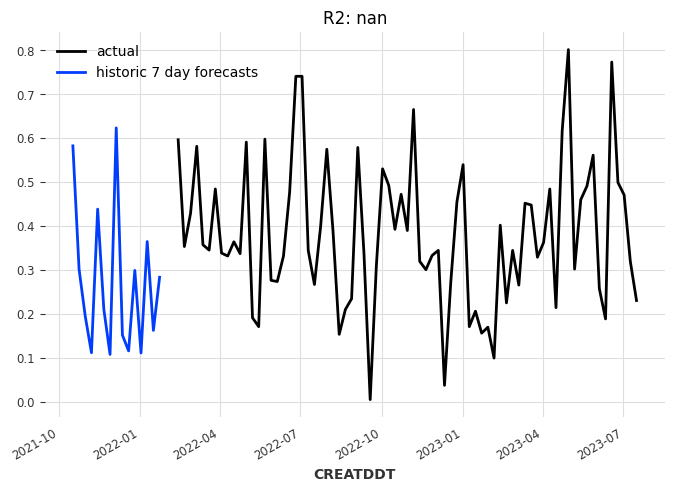

In [7]:
display_forecast(pred_series, modelo.tunne_parameter.data, "7 day", start_date=modelo.tunne_parameter.split_value)

In [8]:
data_frame_predicciones

component,Fecha,predicion,ITEMNMBR
0,2021-10-17,446.718751,SME4-90
1,2021-10-24,238.713669,SME4-90
2,2021-10-31,159.330713,SME4-90
3,2021-11-07,97.991564,SME4-90
4,2021-11-14,340.078512,SME4-90
5,2021-11-21,171.084481,SME4-90
6,2021-11-28,95.148753,SME4-90
7,2021-12-05,477.026105,SME4-90
8,2021-12-12,127.659658,SME4-90
9,2021-12-19,101.066301,SME4-90


In [9]:
create_table(SQLDataSourceFactory(**parameters))

In [10]:
set_data(SQLDataSourceFactory(**parameters), data_frame_predicciones)

{'table': 'modelopredicciones', 'columns': '"Fecha", "predicion", "ITEMNMBR"', '_insert': '%s, %s, %s', 'order': 'index', 'where': 'posicion > 1'}
/home/bdebian/Documents/Projects/Stoke_prediccition/app_prediction/src/data/querys/insert_data.sql
INSERT INTO modelopredicciones ("Fecha", "predicion", "ITEMNMBR")             VALUES (%s, %s, %s)  
component      Fecha   predicion ITEMNMBR
0         2021-10-17  446.718751  SME4-90
1         2021-10-24  238.713669  SME4-90
2         2021-10-31  159.330713  SME4-90
3         2021-11-07   97.991564  SME4-90
4         2021-11-14  340.078512  SME4-90
5         2021-11-21  171.084481  SME4-90
6         2021-11-28   95.148753  SME4-90
7         2021-12-05  477.026105  SME4-90
8         2021-12-12  127.659658  SME4-90
9         2021-12-19  101.066301  SME4-90
10        2021-12-26  236.718133  SME4-90
11        2022-01-02   97.616865  SME4-90
12        2022-01-09  285.421654  SME4-90
13        2022-01-16  135.615499  SME4-90
14        2022-01-23  22

In [ ]:
filter_feature = [column for column in parameters['filter_data'] if re.match(r'filter_\d+_feature', column)]
value_product = []
for i in filter_feature:
    value_product.append(parameters['filter_data'][i])
fecha = parameters['query_template_write']['columns']['0']
min_date = data_frame_predicciones[fecha].min()
max_data = data_frame_predicciones[fecha].max()
metric_columns_pred['init_date'] = data_frame_predicciones[fecha].min()
metric_columns_pred['end_date'] = data_frame_predicciones[fecha].max()
metric_columns_pred['product'] = '/'.join(value_product)

type_data_out = {'Rango':'float',
 'Varianza':'float',
 'Desviacion_estandar':'float',
 'Coeficiente_varianza':'float',
 'Quantile Q1':'float',
 'Quantile Q3':'float',
 'InterQuantile':'float',
 'Desviacion_media_absoluta':'float',
 'init_date':'date',
 'end_date':'date',
 'product':'string'
 }
fix_data_dict = {
'table': 'metric_predict',
'columns': {str(index): key for index ,key in enumerate(type_data_out.keys())},
'order': 'index',
'where': 'posicion > 1'
}

parameters['query_template_write']  = fix_data_dict
parameters['type_data_out'] = type_data_out

create_table(SQLDataSourceFactory(**parameters))
send_metrics  = pd.DataFrame([metric_columns_pred])
set_data(SQLDataSourceFactory(**parameters), send_metrics)

In [39]:
metric_columns_pred['init_date']

Timestamp('2021-10-17 00:00:00')

In [40]:
metric_columns_pred['end_date']

Timestamp('2022-01-23 00:00:00')

In [42]:
filter_date = data_imputation.dataframe[(data_imputation.dataframe['CREATDDT'] >= metric_columns_pred['init_date']) & (
    data_imputation.dataframe['CREATDDT'] <= metric_columns_pred['end_date'])]

In [43]:
filter_date

,CREATDDT,ITEMNMBR,QUANTITY,CUSTNMBR
344837,2022-01-21,FI10X475AH,1,AD130
344838,2022-01-21,FI6X675AH,1,AD130
344839,2022-01-21,TK0475SC-SAMPLE,2,B0198
358313,2022-01-21,EG00056-SAMPLE,2,B0198
358314,2022-01-21,EG00051-SAMPLE,2,B0198
...,...,...,...,...
831465,2022-01-19,EG0080,9,SS0010
831466,2022-01-19,TA0281,10,SS0010
831467,2022-01-19,WA1010,8,SS0010
840809,2022-01-05,SF1105-HD,2,C0142
